In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

colormap = mpl.cm.tab10.colors   # Qualitative colormap

### Plotting functions

In [2]:
def read_scores(file):
    with open(f'/home/fsun/DeepViewAgg/job_logs/{file}') as f:
        lines = f.readlines()

        pattern = 'train_miou ='
        matching_lines = [line for line in lines if pattern in line]
        train_scores = [float(m.split()[-1]) / 100 for m in matching_lines]
        
        pattern = 'train_loss_seg ='
        matching_lines = [line for line in lines if pattern in line]
        train_losses = [float(m.split()[-1]) for m in matching_lines]

        pattern = 'val_miou ='
        matching_lines = [line for line in lines if pattern in line]
        val_scores = [float(m.split()[-1]) / 100 for m in matching_lines]
        
        pattern = 'val_loss_seg ='
        matching_lines = [line for line in lines if pattern in line]
        val_losses = [float(m.split()[-1]) for m in matching_lines]
    
        # Adjust length of lists
        max_len = len(val_scores * 5)
        train_scores = train_scores[:max_len]
        train_losses = train_losses[:max_len]    
    return {'train_scores': train_scores,
            'train_losses': train_losses,
            'val_scores': val_scores,
            'val_losses': val_losses,
    }

def plot_graph(data, log_scale=False):
    plt.figure(figsize=(10,6))
    train_scores = data['train_scores']
    train_losses = data['train_losses']
    val_scores = data['val_scores']
    val_losses = data['val_losses']

#         print(len(val_losses))
#         print(len(range(4, len(train_scores) - len(train_scores) % 5, 5)))

    plt.plot(range(len(train_scores)), train_scores, color=colormap[0], label=f'Train score')
    plt.plot(range(4, len(train_scores) - len(train_scores) % 5, 5), val_scores, color=colormap[1], label=f'Val score')

    plt.plot(range(len(train_losses)), train_losses, color=colormap[2], label=f'Train loss')
    plt.plot(range(4, len(train_losses) - len(train_losses) % 5, 5), val_losses, color=colormap[3], label=f'Val loss')

    # Plot generalization error
    val_range = range(4, len(train_losses) - len(train_losses) % 5, 5)

    gen_error = np.array(val_losses) - np.array([train_losses[i] for i in val_range])
    plt.plot(val_range, gen_error, color=colormap[4], label=f'Generalization error')

    plt.legend()
    plt.title('Model training statistics')
    plt.xlabel('Epochs')
    ax = plt.gca()
    if log_scale:
        ax.set_yscale('log')
    # ax.set_xlim([xmin, xmax])
    # ax.set_ylim([0.6, 0.9])
    plt.grid()

    plt.show()


def plot_barchart(x_range, values, title, ylim=None):
    objects = list(x_range)
    y_pos = np.arange(len(objects))
    performance = values

    plt.figure(figsize=(10,6))
    plt.grid()

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('')
    plt.title(title)
    
    if isinstance(ylim, list):
        ax = plt.gca()
        ax.set_ylim(ylim)

    plt.show()

#### Current model training (M6 with Mix3D)

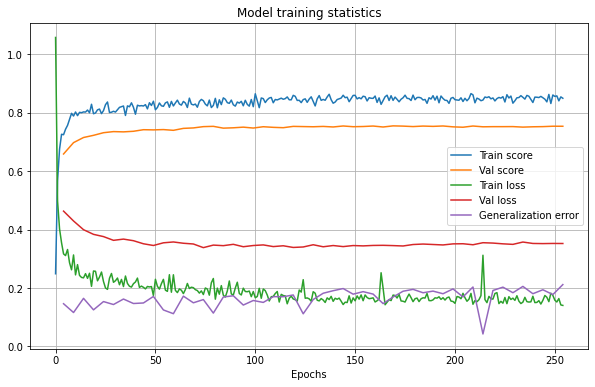

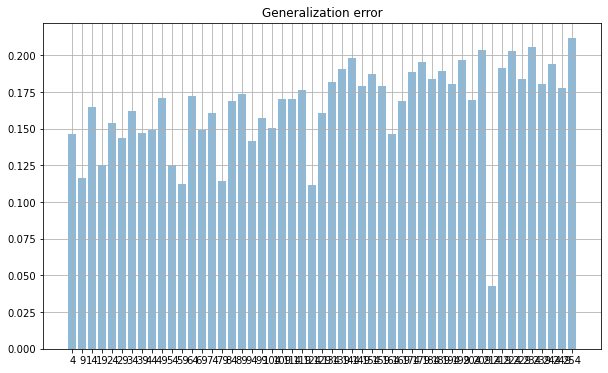

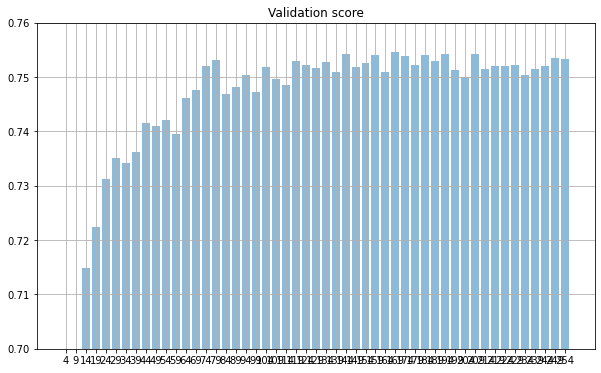

In [3]:
data = read_scores(file='mvfusion_3d_submission/batchsize6_nviews6_maxpoints200000.out')
plot_graph(data, log_scale=False)

# Generalization error
val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
plot_barchart(val_range, gen_error, 'Generalization error')
plot_barchart(val_range, data['val_scores'], 'Validation score', ylim=[0.7, 0.76])

#### Previously submitted model (M1)

M1


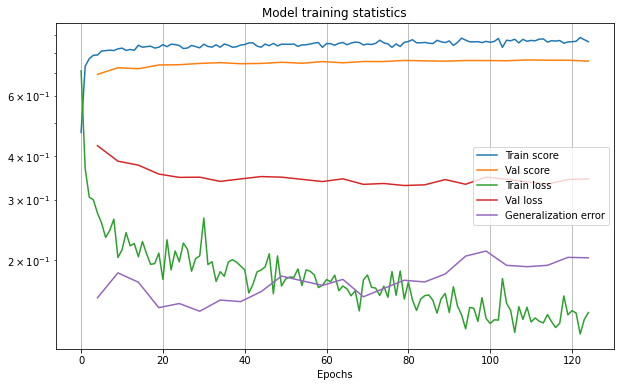

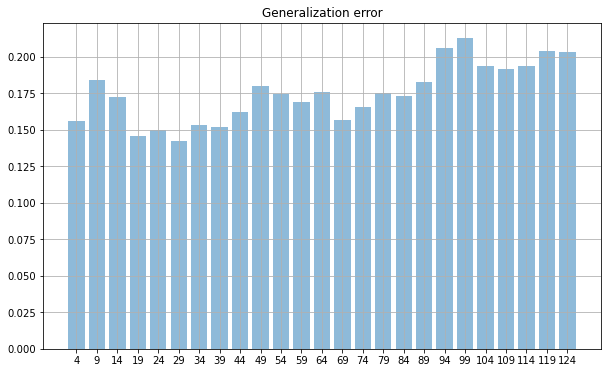

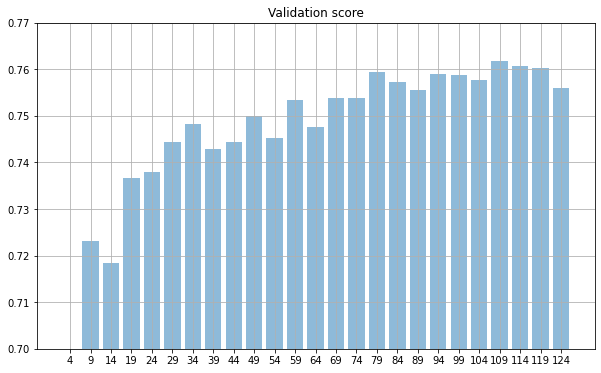

In [4]:
for i in range(1, 2):
    print(f"M{i}")
    data = read_scores(file=f'mvfusion_3d/model_comparison/M{i}.out')
    plot_graph(data, log_scale=True)

    # Generalization error
    val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
    gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
    plot_barchart(val_range, gen_error, 'Generalization error')
    plot_barchart(val_range, data['val_scores'], 'Validation score', ylim=[0.7, 0.77])

# Superconvergence

### Part 1. LR range test (SGD with momentum, wd 1e-4)

In [5]:
# Looked good, take max_lr around 0.3 or lower

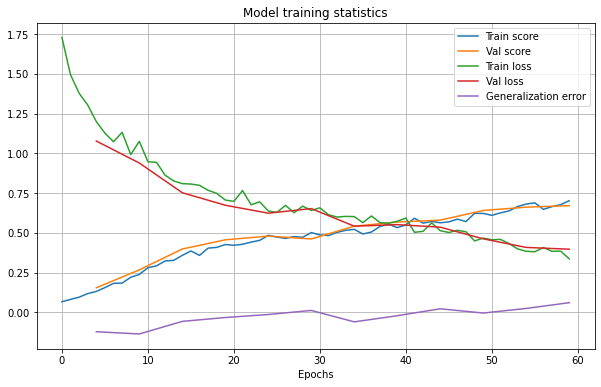

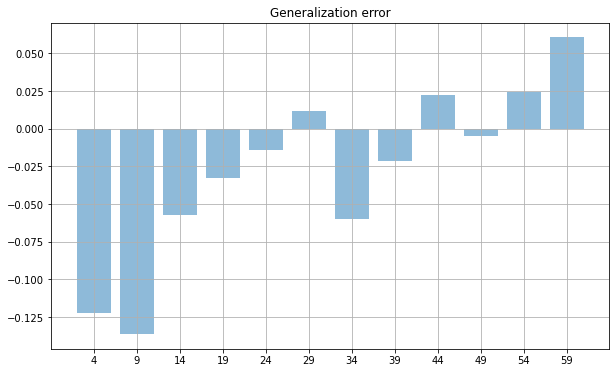

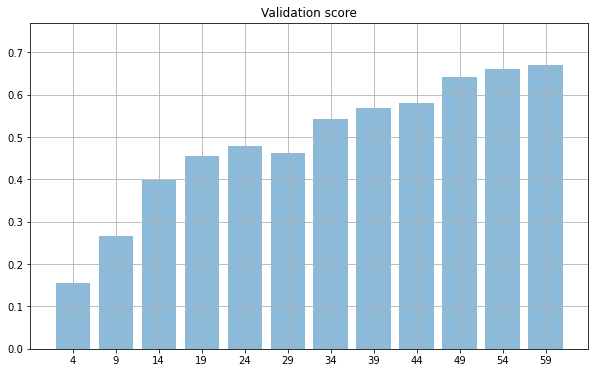

In [6]:
# 3D only
data = read_scores(file='superconvergence/3d_only/train_sgd_wd1e-4_lr0.3.out')
plot_graph(data, log_scale=False)

# Generalization error
val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
plot_barchart(val_range, gen_error, 'Generalization error')
plot_barchart(val_range, data['val_scores'], 'Validation score', ylim=[0.0, 0.77])

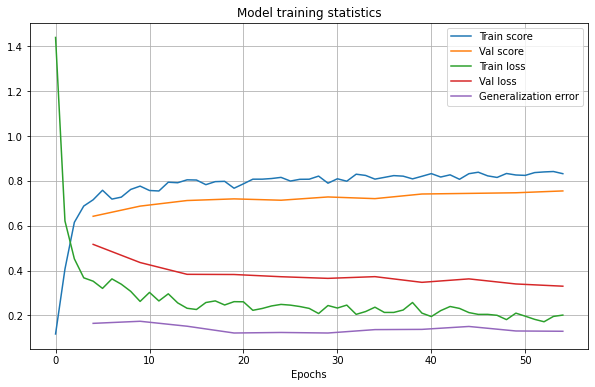

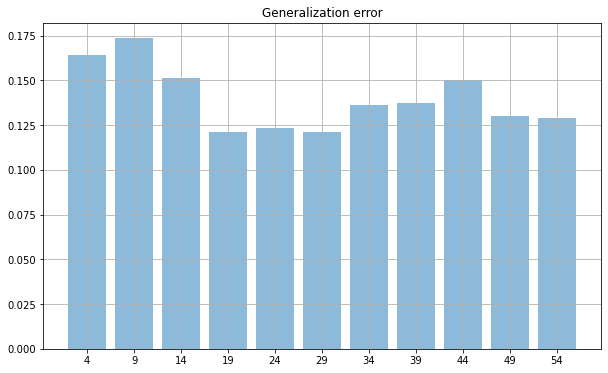

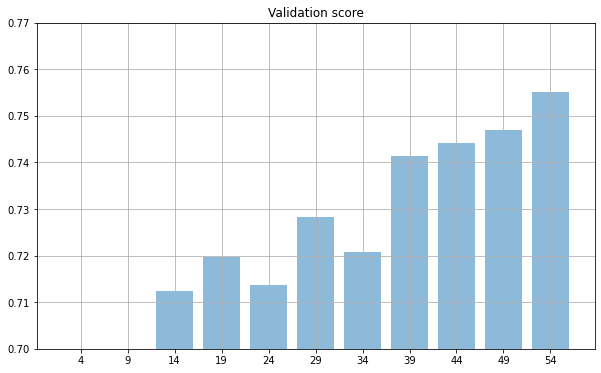

In [7]:
# MVFusion_3D_small

data = read_scores(file='superconvergence/train_sgd_wd1e-4_lr0.3.out')
plot_graph(data, log_scale=False)

# Generalization error
val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
plot_barchart(val_range, gen_error, 'Generalization error')
plot_barchart(val_range, data['val_scores'], 'Validation score', ylim=[0.7, 0.77])

# gradient flow: https://jupyter.lisa.surfsara.nl/2021/user/fsun/view/DeepViewAgg/outputs/2022-11-22/20-41-13/gradient_flow.png

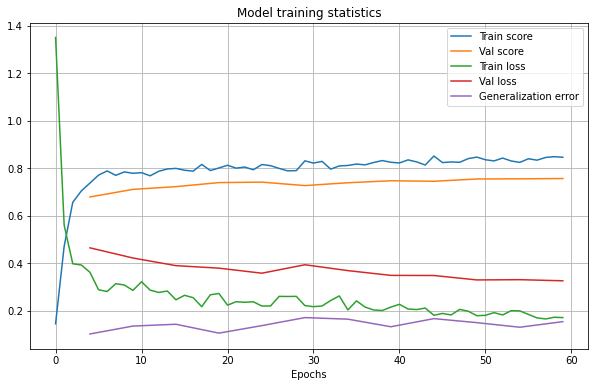

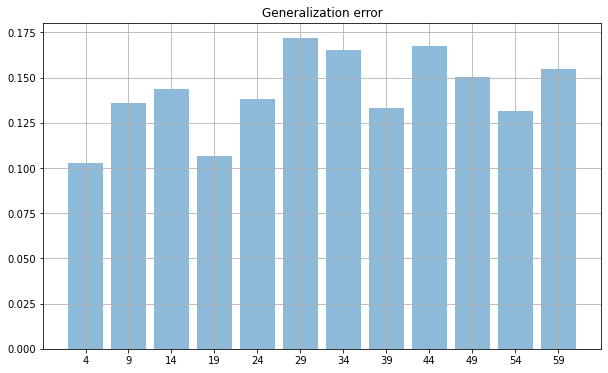

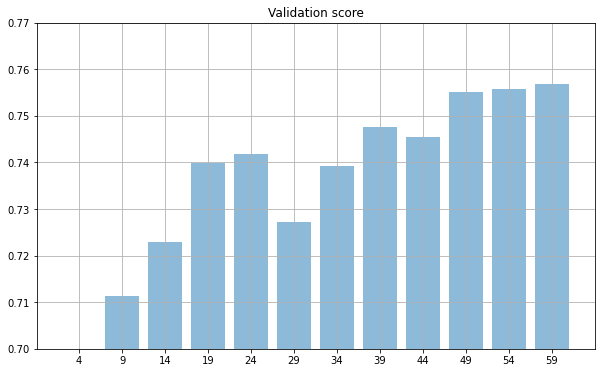

In [8]:
# MVFusion_3D_medium

data = read_scores(file='superconvergence/MVFusion_3D_medium/train_sgd_wd1e-4_lr0.3.out')
plot_graph(data, log_scale=False)

# Generalization error
val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
plot_barchart(val_range, gen_error, 'Generalization error')
plot_barchart(val_range, data['val_scores'], 'Validation score', ylim=[0.7, 0.77])

# gradient flow: https://jupyter.lisa.surfsara.nl/2021/user/fsun/view/DeepViewAgg/outputs/2022-11-22/20-41-13/gradient_flow.png

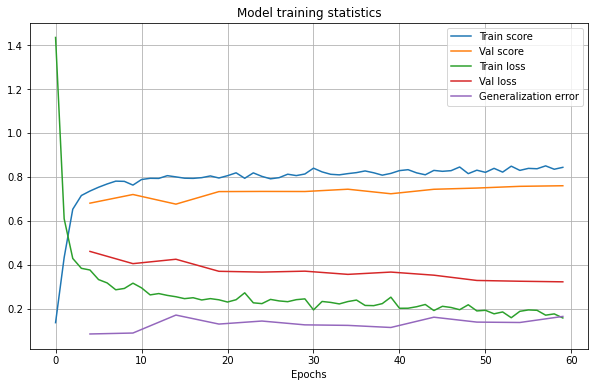

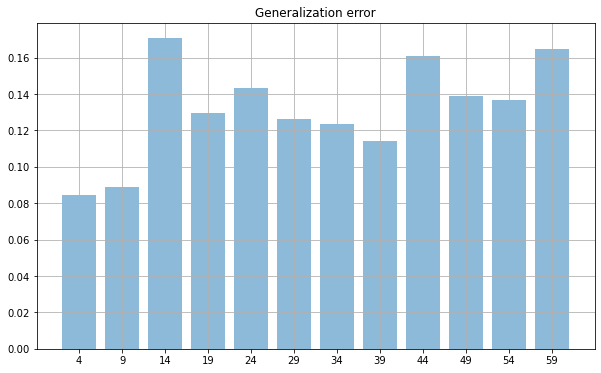

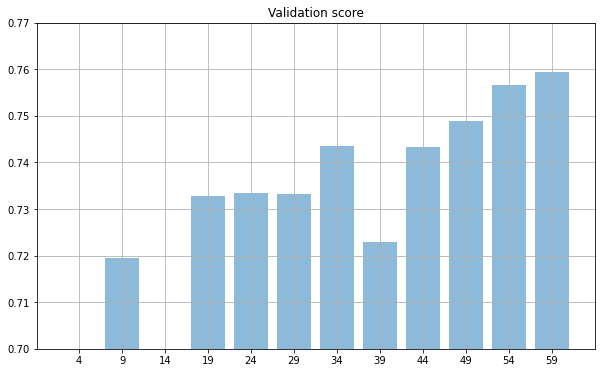

In [13]:
# MVFusion_3D_large

data = read_scores(file='superconvergence/MVFusion_3D_large/train_sgd_wd1e-4_lr0.3.out')
plot_graph(data, log_scale=False)

# Generalization error
val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
plot_barchart(val_range, gen_error, 'Generalization error')
plot_barchart(val_range, data['val_scores'], 'Validation score', ylim=[0.7, 0.77])

# gradient flow: https://jupyter.lisa.surfsara.nl/2021/user/fsun/view/DeepViewAgg/outputs/2022-11-22/20-41-13/gradient_flow.png

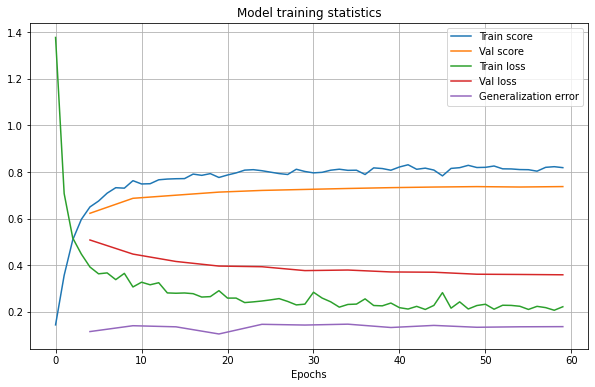

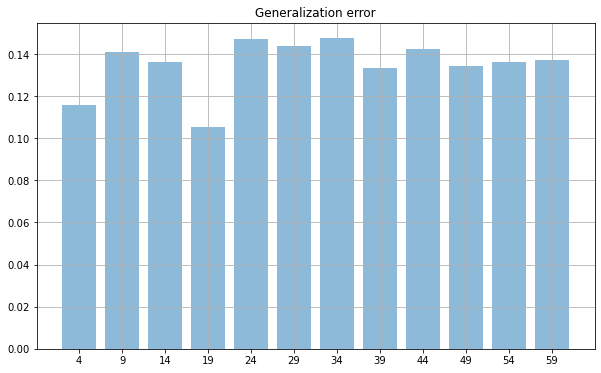

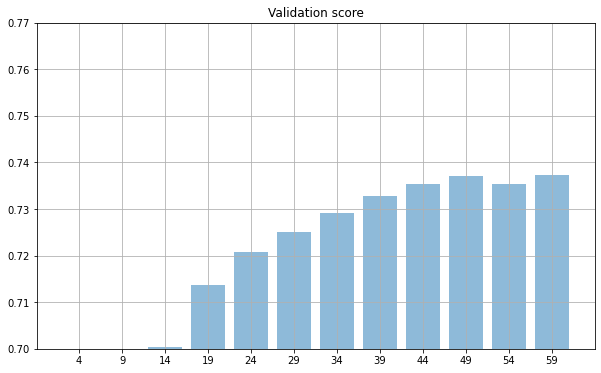

In [10]:
# MVFusion small gating
data = read_scores(file='superconvergence/MVFusion_3D_small/train_sgd_wd1e-4_lr0.3_gating.out')
plot_graph(data, log_scale=False)

# Generalization error
val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
plot_barchart(val_range, gen_error, 'Generalization error')
plot_barchart(val_range, data['val_scores'], 'Validation score', ylim=[0.7, 0.77])

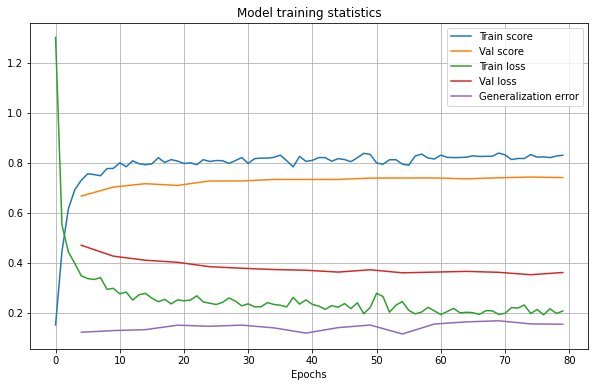

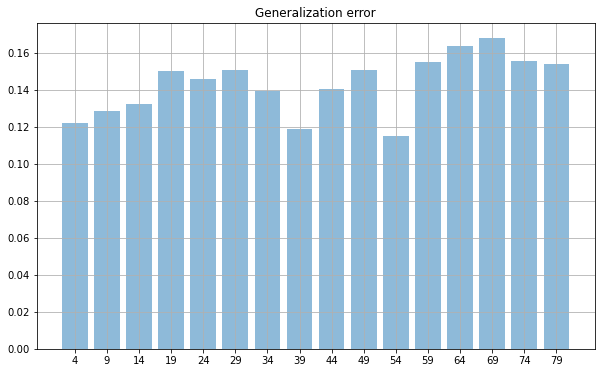

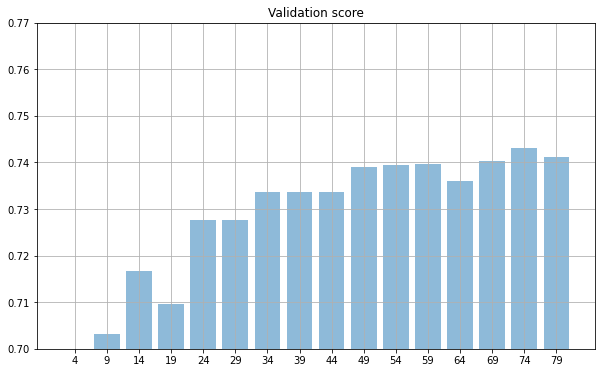

In [12]:
# MVFusion medium 80 epochs
data = read_scores(file='superconvergence/MVFusion_3D_medium/train_sgd_wd1e-4_lr0.3_epochs80.out')
plot_graph(data, log_scale=False)

# Generalization error
val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
plot_barchart(val_range, gen_error, 'Generalization error')
plot_barchart(val_range, data['val_scores'], 'Validation score', ylim=[0.7, 0.77])

In [11]:
# Incorrect, please train again using small model

# # MVFusion small no M2F
# data = read_scores(file='superconvergence/MVFusion_3D_small/train_sgd_wd1e-4_lr0.3_NoM2F.out')
# plot_graph(data, log_scale=False)

# # Generalization error
# val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
# gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
# plot_barchart(val_range, gen_error, 'Generalization error')
# plot_barchart(val_range, data['val_scores'], 'Validation score', ylim=[0.7, 0.77])